# Project Outline:
1. Evaluate goals: 
    - Find drivers for customer churn at Telcho. Why are customers churning?
    - Construct a ML classificatoin model that accurately predicts customer churn.
    - Present your process and findings to the lead data scientist.
2. Data Acquistion
    - Aquire the data from the telco data set
3. Data Preperation
    - Clean the data: 
        - remove columns
        - encode dummies
        - create new features
        - fix datatypes
4. Exploratory data analysis and Hypothesis testing
    - explore the univariate, bivariate, and multivariate variables to create hypothesis
    - test the hypothesis with proper statistical tests
5. Modeling:
    - do some preprocessing
    - find the best model for selected features out of:
        - Decision tree
        - Random forest
        - KNN
        - Logistic regression
    - Complete train, validate, test
6. Create Report

# Imports
Lets grab the important libraies and functions

In [1]:
# base imports
import pandas as pd
import numpy as np

# functions
import wrangle as wr

# vizualizations
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.model_selection import train_test_split

# imports for modeling
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import ConfusionMatrixDisplay

# for knn
from sklearn.neighbors import KNeighborsClassifier

# for decision tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree

# for random forest
from sklearn.ensemble import RandomForestClassifier

# for logistic regression
from sklearn.linear_model import LogisticRegression

# we dont like warnings
import warnings
warnings.filterwarnings("ignore")

# Data Aquisition: 
We need to grab our data from the `telco` data set. To do this we need these functions: 
- `get_db_rul` will take in sql credentials from a private enviornment file to make a connection url
- `new_telco_data` will use the connection url to provide a telco data set given by a specific sql query
- `get_telco_data` will get the telco data from a csv if it exists on the computer. If not it will encode one

In [2]:
# since there is already a telco.cvs, I will go ahead and pull it
telco = wr.get_telco_data()
telco.head()

,payment_type_id,internet_service_type_id,contract_type_id,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,...,tech_support,streaming_tv,streaming_movies,paperless_billing,monthly_charges,total_charges,churn,contract_type,internet_service_type,payment_type
0,2,1,2,0002-ORFBO,Female,0,Yes,Yes,9,Yes,...,Yes,Yes,No,Yes,65.6,593.3,No,One year,DSL,Mailed check
1,2,1,1,0003-MKNFE,Male,0,No,No,9,Yes,...,No,No,Yes,No,59.9,542.4,No,Month-to-month,DSL,Mailed check
2,1,2,1,0004-TLHLJ,Male,0,No,No,4,Yes,...,No,No,No,Yes,73.9,280.85,Yes,Month-to-month,Fiber optic,Electronic check
3,1,2,1,0011-IGKFF,Male,1,Yes,No,13,Yes,...,No,Yes,Yes,Yes,98.0,1237.85,Yes,Month-to-month,Fiber optic,Electronic check
4,2,2,1,0013-EXCHZ,Female,1,Yes,No,3,Yes,...,Yes,Yes,No,Yes,83.9,267.4,Yes,Month-to-month,Fiber optic,Mailed check


# Data Preperation:
Well would you look at that, the data is messy! Lets stress clean it up!
1. I need to remove the duplicate columns
2. Change a nasty data type
3. Split my data

In [3]:
# lets first get a glance:
telco.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 24 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   payment_type_id           7043 non-null   int64  
 1   internet_service_type_id  7043 non-null   int64  
 2   contract_type_id          7043 non-null   int64  
 3   customer_id               7043 non-null   object 
 4   gender                    7043 non-null   object 
 5   senior_citizen            7043 non-null   int64  
 6   partner                   7043 non-null   object 
 7   dependents                7043 non-null   object 
 8   tenure                    7043 non-null   int64  
 9   phone_service             7043 non-null   object 
 10  multiple_lines            7043 non-null   object 
 11  online_security           7043 non-null   object 
 12  online_backup             7043 non-null   object 
 13  device_protection         7043 non-null   object 
 14  tech_sup

In [4]:
telco.describe()

,payment_type_id,internet_service_type_id,contract_type_id,senior_citizen,tenure,monthly_charges
count,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000
mean,2.315633,1.872923,1.690473,0.162147,32.371149,64.761692
std,1.148907,0.737796,0.833755,0.368612,24.559481,30.090047
min,1.000000,1.000000,1.000000,0.000000,0.000000,18.250000
25%,1.000000,1.000000,1.000000,0.000000,9.000000,35.500000
50%,2.000000,2.000000,1.000000,0.000000,29.000000,70.350000
75%,3.000000,2.000000,2.000000,0.000000,55.000000,89.850000
max,4.000000,3.000000,3.000000,1.000000,72.000000,118.750000


In [5]:
# how do i know which colums are duplicate?
pd.crosstab(telco.contract_type_id, telco.contract_type)

contract_type,Month-to-month,One year,Two year
contract_type_id,,,
1,3875,0,0
2,0,1473,0
3,0,0,1695


## Lets make this easy. How? Functions!
- `clean_telco_data` is a function that drops the duplicate columns and also encodes my total charges as a float!
- `split_telco_data` will run clean telco, and then split the data into train, validate, and test

In [6]:
# call the function: 
train, val, test = wr.split_telco_data(telco)
train.head()

,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,online_security,online_backup,...,streaming_tv,streaming_movies,paperless_billing,monthly_charges,total_charges,churn,contract_type,internet_service_type,payment_type,did_churn
84,0135-NMXAP,Female,0,No,No,12,Yes,Yes,No,Yes,...,Yes,No,Yes,89.75,1052.40,Yes,Month-to-month,Fiber optic,Bank transfer (automatic),1
5021,7055-JCGNI,Female,0,No,No,70,Yes,Yes,Yes,Yes,...,Yes,Yes,Yes,111.95,7795.95,No,Two year,Fiber optic,Credit card (automatic),0
1577,2296-DKZFP,Female,0,Yes,No,65,Yes,No,Yes,Yes,...,No,Yes,No,71.00,4386.20,No,Two year,DSL,Bank transfer (automatic),0
6366,9025-AOMKI,Female,0,No,No,6,Yes,Yes,No,No,...,Yes,Yes,Yes,93.55,536.40,Yes,Month-to-month,Fiber optic,Bank transfer (automatic),1
3387,4817-VYYWS,Female,0,No,No,30,Yes,Yes,No,Yes,...,Yes,Yes,Yes,100.20,2983.80,Yes,Month-to-month,Fiber optic,Electronic check,1


# Exploratory Analysis:
1. Have to do some preprocessing
2. Have to look at Univariate stats: Numerical and Categorical Variables
3. Have to look at Bivariate stats
4. Have to look at Multivariate stats

### Preprocessing: 
I made a dummy column for churn (aka 0 = No and 1 = Yes) <br>
I had to make numerical and categorical columns first, and this is what i got! <Br>
- `cat_cols` = ['gender',
 'senior_citizen',
 'partner',
 'dependents',
 'phone_service',
 'multiple_lines',
 'online_security',
 'online_backup',
 'device_protection',
 'tech_support',
 'streaming_tv',
 'streaming_movies',
 'paperless_billing',
 'churn',
 'contract_type',
 'internet_service_type',
 'payment_type',
 'did_churn']
- `num_cols` = ['tenure', 'monthly_charges', 'total_charges']


In [7]:
train.head()

,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,online_security,online_backup,...,streaming_tv,streaming_movies,paperless_billing,monthly_charges,total_charges,churn,contract_type,internet_service_type,payment_type,did_churn
84,0135-NMXAP,Female,0,No,No,12,Yes,Yes,No,Yes,...,Yes,No,Yes,89.75,1052.40,Yes,Month-to-month,Fiber optic,Bank transfer (automatic),1
5021,7055-JCGNI,Female,0,No,No,70,Yes,Yes,Yes,Yes,...,Yes,Yes,Yes,111.95,7795.95,No,Two year,Fiber optic,Credit card (automatic),0
1577,2296-DKZFP,Female,0,Yes,No,65,Yes,No,Yes,Yes,...,No,Yes,No,71.00,4386.20,No,Two year,DSL,Bank transfer (automatic),0
6366,9025-AOMKI,Female,0,No,No,6,Yes,Yes,No,No,...,Yes,Yes,Yes,93.55,536.40,Yes,Month-to-month,Fiber optic,Bank transfer (automatic),1
3387,4817-VYYWS,Female,0,No,No,30,Yes,Yes,No,Yes,...,Yes,Yes,Yes,100.20,2983.80,Yes,Month-to-month,Fiber optic,Electronic check,1


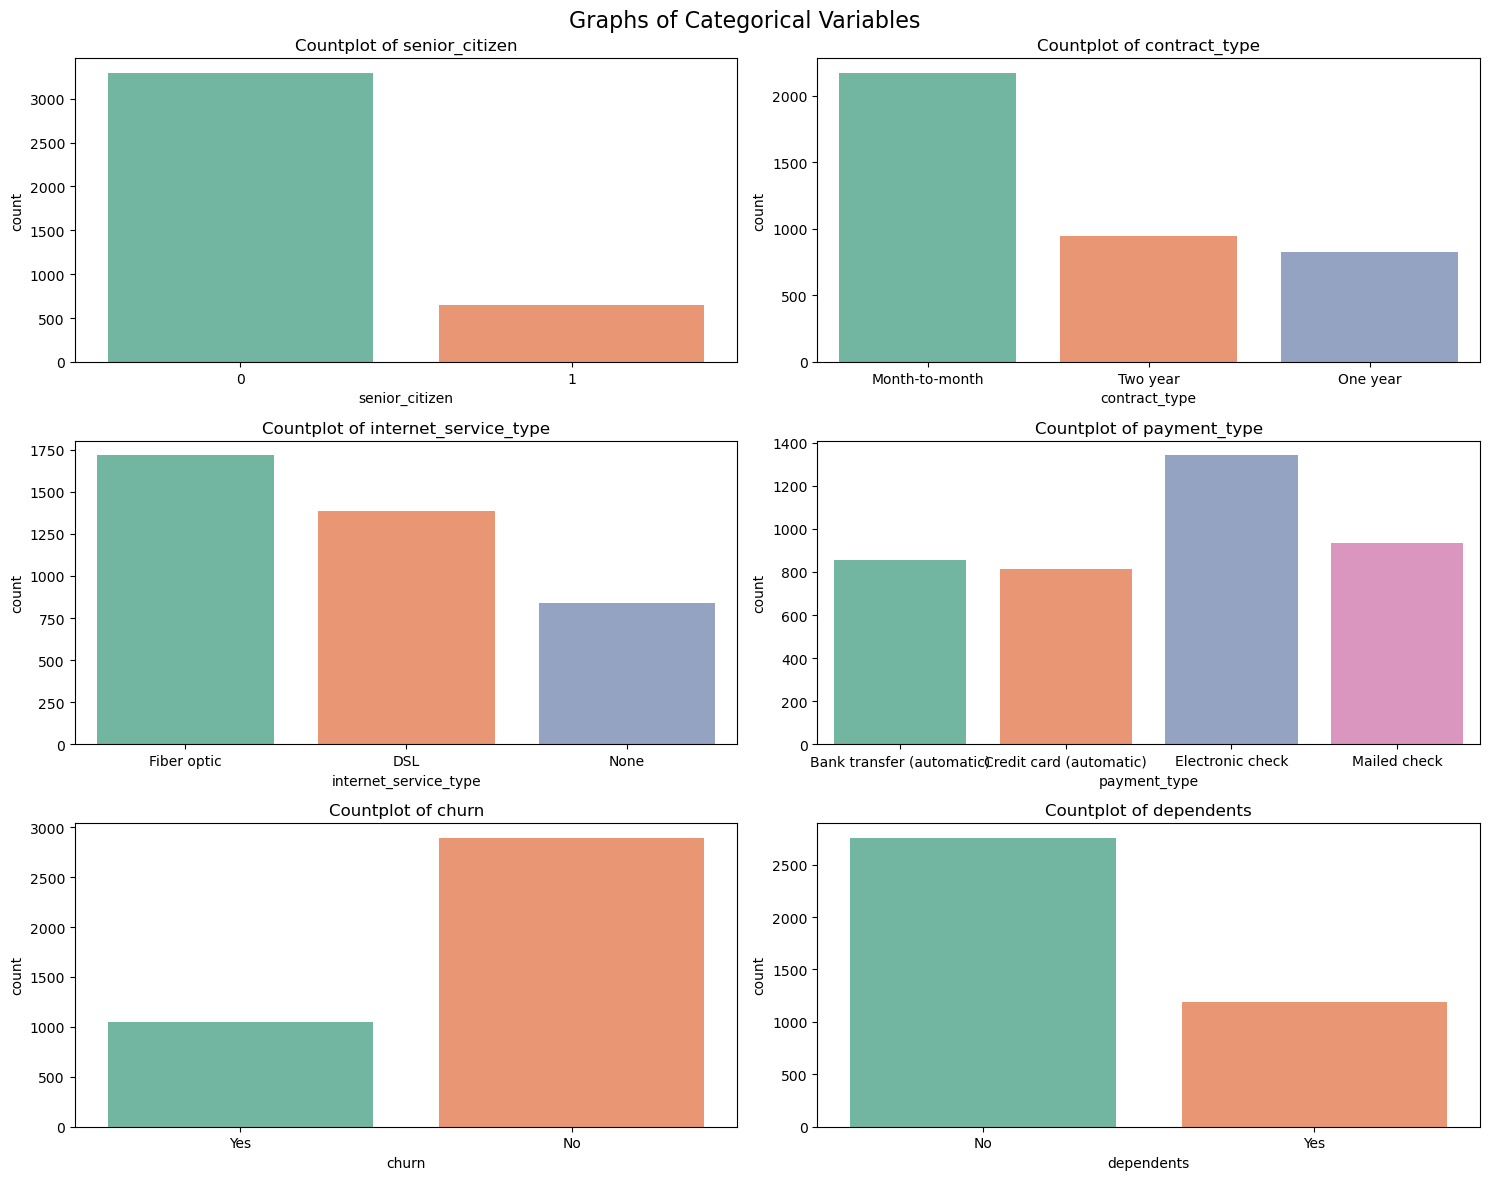

In [8]:
# lets take a look: 
wr.visualize_univariate_cat_final(train)

<div class="alert alert-success" role="alert">

Univariate stats: Takeaways: <br>
    
    
Numerical Variables: 
- Total charges has a postive skew moslty around lower total_charges.
    - There are a large amount of outliers
- Monthly charges looks to be more binomial, with peak around the lower charges. 
- Tenure shows a higher amount of customers either being new or older but a lower amount in the mean tenure range. <br>

Calcluations:
- None of the data is normally distributed

<br>
Categorical Variables: <br>
- Why dont we take a look? <br>
- Some take aways not here: There seem to be a high ration of people who do not use the services that telco provides:<br>
        - online security <br>
        - online backup <br>
        - device protection <br>
        - tech support <br>
        - streaming tv <br>
        - streaming movies <br>

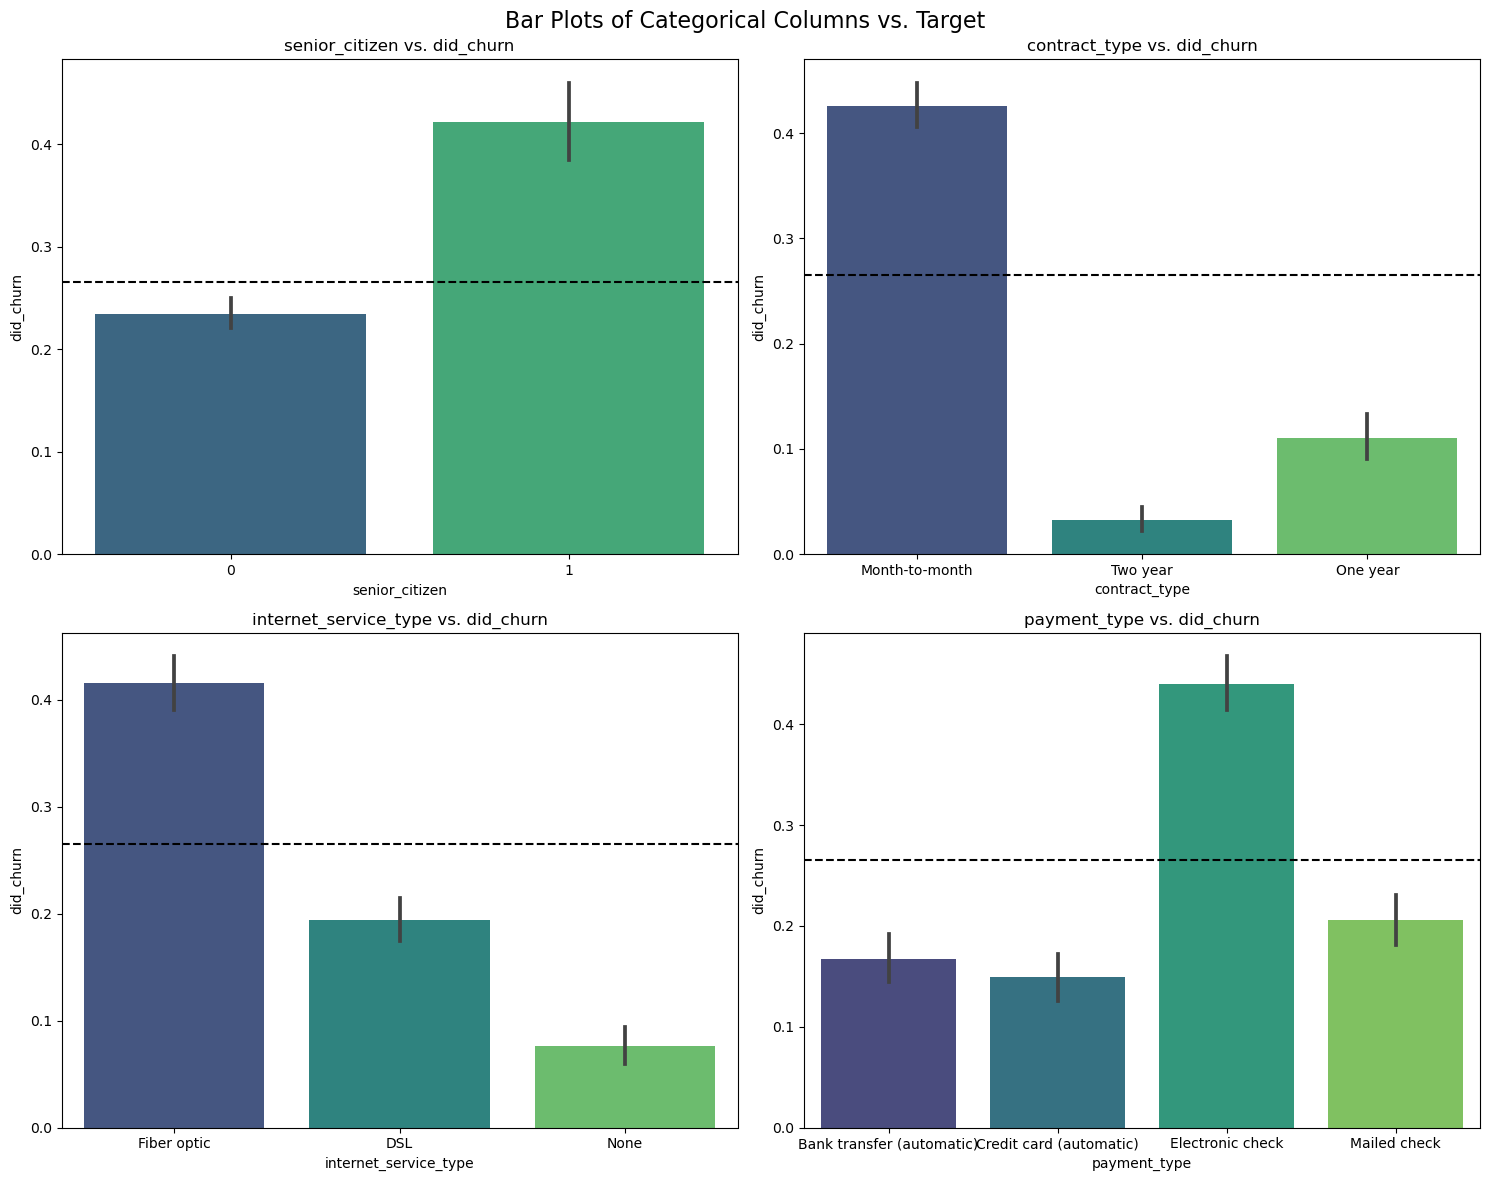

In [9]:
# look at specific barplots for bivariate for categorical
target = 'did_churn'
wr.create_subplots_barplots_categorical_vs_target(train, target)

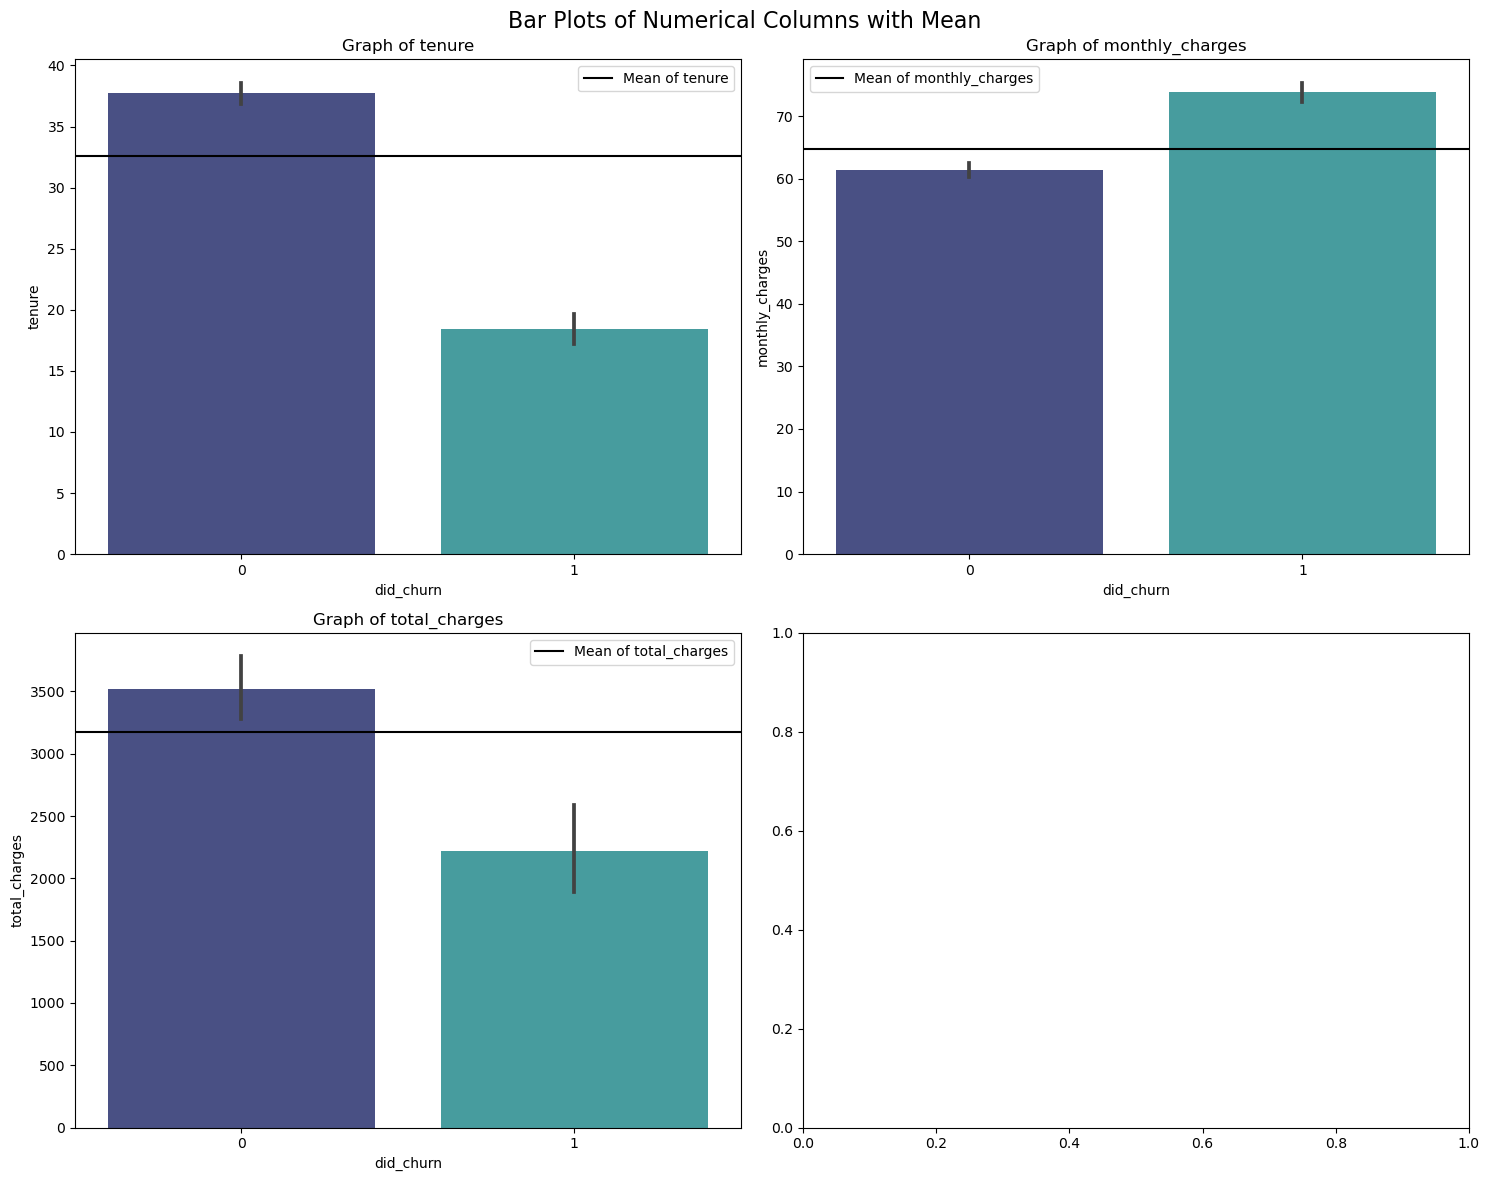

In [10]:
# lets look at bivaraite numerical comparison
target = 'did_churn'
wr.create_subplots_barplots_with_mean(train, target)

<div class="alert alert-success" role="alert">
Bivariate Takeaways: <br>
- Tenure does not seem to influence churn <br>
- Monthly_Charges is an important feature to have to look at <br>
- Total charges also does not seem to influence churn <br>
    
- Look into senior citizen, contract type, internet service type, and payment type

## Hypothesis testing: 
- I initally created 5 hypothesis. I listed 4 of them here. They all are categorical vs categorical, so they must undergo a chi2 test. The 5th one that is not listed is a categorical vs continous. To test that a mann-whitney test was run to find the data not normally distributed and then a spearmens test was run to find thre relationship. 

### Hypothesis 1:
1. Are customers more likley to churn if they are a senior citizen <br>
$H_0$: Senior citizen and churn are independent of each other <br>
$H_a$: Senior citizen and churn are dependent on each other <br>

In [11]:
# create null and alternative
null_hypothesis = 'Senior citizen and churn are independent of each other.'
alternative_hypothesis = 'Senior citizen and churn are dependent on each other.'
# run a crosstab
observed = pd.crosstab(train.senior_citizen, train[target])
observed

did_churn,0,1
senior_citizen,,
0,2522,773
1,375,273


In [12]:
# calculate chi2
chi2, p, degf, expected = stats.chi2_contingency(observed)
alpha = 0.05
# print out if the null is rejected or not
if p < alpha:
    print(f"We reject the null hypothesis: {null_hypothesis}")
    print(f"Therefore: {alternative_hypothesis}")
else:
    print(f"We fail to reject the null, therefore: {null_hypothesis}")
    print(f"P-value: {p}")

We reject the null hypothesis: Senior citizen and churn are independent of each other.
Therefore: Senior citizen and churn are dependent on each other.


### Hyothesis 2: 
1. Are customers more likley to churn due to contract type? <br>
$H_0$: Contract type and churn are independent of each other. <br>
$H_a$: Contract type and churn are dependent on each other. <br>

In [13]:
# create null and alternative
null_hypothesis = 'Contract type and churn are independent of each other.'
alternative_hypothesis = 'Contract type and churn are dependent on each other.'
# print out if the null is rejected or not
observed = pd.crosstab(train.contract_type, train[target])
observed

did_churn,0,1
contract_type,,
Month-to-month,1247,924
One year,735,91
Two year,915,31


In [14]:
# calculate chi2
chi2, p, degf, expected = stats.chi2_contingency(observed)
alpha = 0.05
# print out if the null is rejected or not
if p < alpha:
    print(f"We reject the null hypothesis: {null_hypothesis}")
    print(f"Therefore: {alternative_hypothesis}")
else:
    print(f"We fail to reject the null, therefore: {null_hypothesis}")
    print(f"P-value: {p}")

We reject the null hypothesis: Contract type and churn are independent of each other.
Therefore: Contract type and churn are dependent on each other.


### Hypothesis 3: 
2. Are customer more likley to churn due to payment type? <br>
$H_0$: Payment type and churn are independent of each other. <br>
$H_a$: Payment type and churn are dependent on each other. <br>

In [15]:
# create hypothesis variables
null_hypothesis = 'Payment type and churn are independent of each other.'
alternative_hypothesis = 'Payment type and churn are dependent on each other.'
# make crosstable
observed = pd.crosstab(train.payment_type, train[target])
observed

did_churn,0,1
payment_type,,
Bank transfer (automatic),712,143
Credit card (automatic),692,121
Electronic check,752,590
Mailed check,741,192


In [16]:
# function to see if we reject null or not
wr.perform_chi_squared_test(observed, null_hypothesis, alternative_hypothesis)

We reject the null hypothesis: Payment type and churn are independent of each other.
Therefore: Payment type and churn are dependent on each other.
P-value: 3.877716949659107e-70


### Hypothesis 4: 
2. Are customer more likley to churn due to internet service type? <br>
$H_0$: Internet type and churn are independent of each other. <br>
$H_a$: Internet type and churn are dependent on each other. <br>

In [17]:
# hypothesis varibles
null_hypothesis = 'Internet type and churn are independent of each other.'
alternative_hypothesis = 'Internet type and churn are dependent on each other.'
# create crosstab
observed = pd.crosstab(train.internet_service_type, train[target])
observed

did_churn,0,1
internet_service_type,,
DSL,1115,269
Fiber optic,1004,713
None,778,64


In [18]:
# preform the test
wr.perform_chi_squared_test(observed, null_hypothesis, alternative_hypothesis)

We reject the null hypothesis: Internet type and churn are independent of each other.
Therefore: Internet type and churn are dependent on each other.
P-value: 4.0884960860642045e-85


# Modeling!
- We have our features:
    - senior citizen
    - monthly charge
    - contract type
    - internet type
    - payment type
- I have already found my best models: 
    - I did this by analysis train and validate to see if accuracy dropped of my model was overfit
    - Decision Tree
    - Random Forest
    - Logistic Regression

Positive = no_churn or 0 <br>
Negavite = churn or 1

|                   | Predicted Positive (no_churn) | Predicted Negative (churn) |
|-------------------|-------------------------------|-----------------------------|
| Actual Positive   | True Positive (TP)            | False Negative (FN)        |
|                   | Predited no_chun, actual no churn| Predicted churn, actual no churn|
|
| Actual Negative   | False Positive (FP)           | True Negative (TN)         |
|                   | predicted no churn, actual churn| predicted churn, actual churn

False Positive is Worse! If the graph predicts that the don't churn but they do we might cause the company to lose money!

#### Lets first preprocess:
- I created a new function to clean the telco data specifically for modeling. 
- `create_dummy_columns` = will code dummy columns
- `train, validate, split` = will make train, val, split
- `drop coloumns` = will drop columns i dont want

In [19]:
# get data:
telco = wr.new_telco_data()
telco.head()

,payment_type_id,internet_service_type_id,contract_type_id,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,...,tech_support,streaming_tv,streaming_movies,paperless_billing,monthly_charges,total_charges,churn,contract_type,internet_service_type,payment_type
0,2,1,2,0002-ORFBO,Female,0,Yes,Yes,9,Yes,...,Yes,Yes,No,Yes,65.6,593.3,No,One year,DSL,Mailed check
1,2,1,1,0003-MKNFE,Male,0,No,No,9,Yes,...,No,No,Yes,No,59.9,542.4,No,Month-to-month,DSL,Mailed check
2,1,2,1,0004-TLHLJ,Male,0,No,No,4,Yes,...,No,No,No,Yes,73.9,280.85,Yes,Month-to-month,Fiber optic,Electronic check
3,1,2,1,0011-IGKFF,Male,1,Yes,No,13,Yes,...,No,Yes,Yes,Yes,98.0,1237.85,Yes,Month-to-month,Fiber optic,Electronic check
4,2,2,1,0013-EXCHZ,Female,1,Yes,No,3,Yes,...,Yes,Yes,No,Yes,83.9,267.4,Yes,Month-to-month,Fiber optic,Mailed check


In [20]:
#clean the model
telco  = wr.clean_telco_model()
telco.head()

,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,online_security,online_backup,...,streaming_tv,streaming_movies,paperless_billing,monthly_charges,total_charges,churn,contract_type,internet_service_type,payment_type,did_churn
0,0002-ORFBO,Female,0,Yes,Yes,9,Yes,No,No,Yes,...,Yes,No,Yes,65.6,593.30,No,One year,DSL,Mailed check,0
1,0003-MKNFE,Male,0,No,No,9,Yes,Yes,No,No,...,No,Yes,No,59.9,542.40,No,Month-to-month,DSL,Mailed check,0
2,0004-TLHLJ,Male,0,No,No,4,Yes,No,No,No,...,No,No,Yes,73.9,280.85,Yes,Month-to-month,Fiber optic,Electronic check,1
3,0011-IGKFF,Male,1,Yes,No,13,Yes,No,No,Yes,...,Yes,Yes,Yes,98.0,1237.85,Yes,Month-to-month,Fiber optic,Electronic check,1
4,0013-EXCHZ,Female,1,Yes,No,3,Yes,No,No,No,...,Yes,No,Yes,83.9,267.40,Yes,Month-to-month,Fiber optic,Mailed check,1


In [21]:
#create dummies
telco = wr.create_dummy_columns(telco)

In [22]:
# create the train, val, split
train, val, test = wr.train_validate_test(telco)
train.head()

,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,online_security,online_backup,...,streaming_movies_No internet service,streaming_movies_Yes,paperless_billing_Yes,contract_type_One year,contract_type_Two year,internet_service_type_Fiber optic,internet_service_type_None,payment_type_Credit card (automatic),payment_type_Electronic check,payment_type_Mailed check
448,0661-KBKPA,Male,0,Yes,Yes,53,Yes,Yes,No,No,...,0,1,1,1,0,0,0,0,0,1
168,0269-XFESX,Male,0,Yes,Yes,23,Yes,Yes,No internet service,No internet service,...,1,0,0,1,0,0,1,0,0,1
1718,2506-CLAKW,Female,0,No,No,6,Yes,No,Yes,Yes,...,0,1,1,0,0,1,0,0,0,0
6600,9381-NDKME,Female,1,Yes,No,24,No,No phone service,No,No,...,0,1,1,0,0,0,0,1,0,0
4033,5687-DKDTV,Female,0,No,No,4,Yes,No,No internet service,No internet service,...,1,0,0,0,0,0,1,0,0,1


In [23]:
# drop columns
train, val , test = wr.drop_columns(train, val, test)
train.head()

,tenure,monthly_charges,total_charges,did_churn,gender_Male,senior_citizen_1,partner_Yes,dependents_Yes,phone_service_Yes,multiple_lines_No phone service,...,streaming_movies_No internet service,streaming_movies_Yes,paperless_billing_Yes,contract_type_One year,contract_type_Two year,internet_service_type_Fiber optic,internet_service_type_None,payment_type_Credit card (automatic),payment_type_Electronic check,payment_type_Mailed check
customer_id,,,,,,,,,,,,,,,,,,,,,
0661-KBKPA,53,78.75,3942.45,0,1,0,1,1,1,0,...,0,1,1,1,0,0,0,0,0,1
0269-XFESX,23,24.35,538.50,0,1,0,1,1,1,0,...,1,0,0,1,0,0,1,0,0,1
2506-CLAKW,6,98.15,567.45,1,0,0,0,0,1,0,...,0,1,1,0,0,1,0,0,0,0
9381-NDKME,24,40.65,933.30,1,0,1,1,0,0,1,...,0,1,1,0,0,0,0,1,0,0
5687-DKDTV,4,20.35,77.50,1,0,0,0,0,1,0,...,1,0,0,0,0,0,1,0,0,1


### Steps:
1. Baseline
2. Variables
3. Choose: Validate
4. Model test!

In [24]:
#what is out baseline?
# create baseline
baseline_accuracy = (train.did_churn == 0).mean()
baseline_accuracy

0.7347197565305605

In [25]:
# features we are looking at: payment
# create x and y
features = ['senior_citizen_1', 'contract_type_One year', 'contract_type_Two year', 
            'internet_service_type_Fiber optic', 'internet_service_type_None',
           'monthly_charges',
            'payment_type_Credit card (automatic)','payment_type_Electronic check','payment_type_Mailed check']

X_train = train[features]
y_train = train.did_churn

X_val = val[features]
y_val = val.did_churn

X_test = test[features]
y_test = test.did_churn

In [26]:
X_train.head()

,senior_citizen_1,contract_type_One year,contract_type_Two year,internet_service_type_Fiber optic,internet_service_type_None,monthly_charges,payment_type_Credit card (automatic),payment_type_Electronic check,payment_type_Mailed check
customer_id,,,,,,,,,
0661-KBKPA,0,1,0,0,0,78.75,0,0,1
0269-XFESX,0,1,0,0,1,24.35,0,0,1
2506-CLAKW,0,0,0,1,0,98.15,0,0,0
9381-NDKME,1,0,0,0,0,40.65,1,0,0
5687-DKDTV,0,0,0,0,1,20.35,0,0,1


#### Decision Tree: 

In [27]:
# Create the object
clf = DecisionTreeClassifier(max_depth=7, random_state=123)

In [28]:
#fit the object
clf = clf.fit(X_train, y_train)

In [29]:
# use the object 
clf.predict(X_train)

array([0, 0, 1, ..., 0, 0, 0])

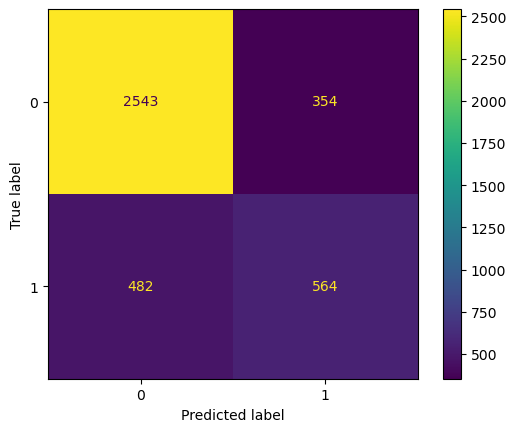

In [30]:
ConfusionMatrixDisplay.from_estimator(clf, X_train, y_train);

In [31]:
# predictions:
y_pred = clf.predict(X_train)
conf = confusion_matrix(y_train, y_pred)
TN, FP, FN, TP = conf.ravel()
wr.calculate_classification_metrics(TN, FP, FN, TP )

Accuracy: 0.7879786964240426

True Positive Rate/Sensitivity/Recall/Power: 0.5391969407265774
False Positive Rate/False Alarm Ratio/Fall-out: 0.12219537452537108
True Negative Rate/Specificity/Selectivity: 0.8778046254746289
False Negative Rate/Miss Rate: 0.4608030592734226

Precision/PPV: 0.6143790849673203
F1 Score: 0.5743380855397148

Support (0): 1046
Support (1): 2897


In [54]:
# validate: 
y_pred_val = clf.predict(X_val)
conf = confusion_matrix(y_val, y_pred_val)
clf.score(X_val, y_val)
TN, FP, FN, TP = conf.ravel()
wr.calculate_classification_metrics(TN, FP, FN, TP )

Accuracy: 0.7782377291543465

True Positive Rate/Sensitivity/Recall/Power: 0.49443207126948774
False Positive Rate/False Alarm Ratio/Fall-out: 0.11916264090177134
True Negative Rate/Specificity/Selectivity: 0.8808373590982287
False Negative Rate/Miss Rate: 0.5055679287305123

Precision/PPV: 0.6
F1 Score: 0.5421245421245421

Support (0): 449
Support (1): 1242


In [33]:
conf.ravel()

array([2543,  354,  482,  564])

In [34]:
#double checking my confusion matrix
y_train_df = pd.Series(y_train)
labels = sorted(y_train_df.unique())
pd.DataFrame(conf,
            index=[str(label) + '_actual'for label in labels],
            columns=[str(label) + '_predict'for label in labels])

,0_predict,1_predict
0_actual,2543,354
1_actual,482,564


#### Random Forest:

In [35]:
#best model with info:
# Make the model
forest = RandomForestClassifier(max_depth=7, min_samples_leaf = 7, random_state=124)

# Fit the model (on train and only train)
forest.fit(X_train, y_train)

# Use the model
y_pred = forest.predict(X_train)

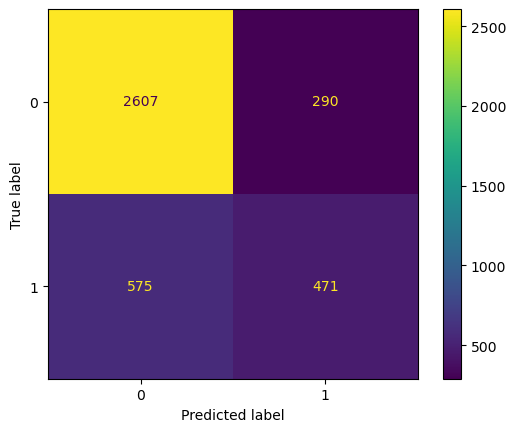

In [36]:
ConfusionMatrixDisplay.from_estimator(forest, X_train, y_train);

In [37]:
# calculate with predictions
conf = confusion_matrix(y_train, y_pred)
TN, FP, FN, TP = conf.ravel()
wr.calculate_classification_metrics(TN, FP, FN, TP )

Accuracy: 0.7806238904387522

True Positive Rate/Sensitivity/Recall/Power: 0.4502868068833652
False Positive Rate/False Alarm Ratio/Fall-out: 0.10010355540214015
True Negative Rate/Specificity/Selectivity: 0.8998964445978599
False Negative Rate/Miss Rate: 0.5497131931166348

Precision/PPV: 0.6189224704336399
F1 Score: 0.5213060320973989

Support (0): 1046
Support (1): 2897


In [53]:
# validate: 
y_pred_val = forest.predict(X_val)
conf = confusion_matrix(y_val, y_pred_val)
forest.score(X_val, y_val)
TN, FP, FN, TP = conf.ravel()
wr.calculate_classification_metrics(TN, FP, FN, TP )

Accuracy: 0.7882909520993495

True Positive Rate/Sensitivity/Recall/Power: 0.42538975501113585
False Positive Rate/False Alarm Ratio/Fall-out: 0.08051529790660225
True Negative Rate/Specificity/Selectivity: 0.9194847020933977
False Negative Rate/Miss Rate: 0.5746102449888641

Precision/PPV: 0.6563573883161512
F1 Score: 0.5162162162162162

Support (0): 449
Support (1): 1242


#### Logistic Regression: 

In [39]:
# create object
logit = LogisticRegression(C = 0.0541, random_state=123)

In [40]:
#fit it
logit.fit(X_train, y_train)

LogisticRegression(C=0.0541, random_state=123)

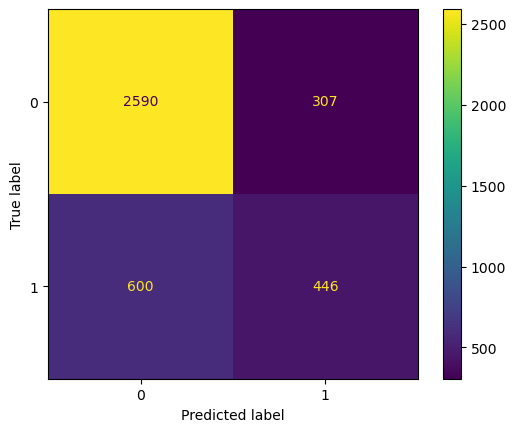

In [41]:
ConfusionMatrixDisplay.from_estimator(logit, X_train, y_train);

In [42]:
# make predictions
y_pred = logit.predict(X_train)
logit.score(X_train, y_train)
TN, FP, FN, TP = conf.ravel()
wr.calculate_classification_metrics(TN, FP, FN, TP )

Accuracy: 0.7806238904387522

True Positive Rate/Sensitivity/Recall/Power: 0.4502868068833652
False Positive Rate/False Alarm Ratio/Fall-out: 0.10010355540214015
True Negative Rate/Specificity/Selectivity: 0.8998964445978599
False Negative Rate/Miss Rate: 0.5497131931166348

Precision/PPV: 0.6189224704336399
F1 Score: 0.5213060320973989

Support (0): 1046
Support (1): 2897


In [55]:
# validate: 
y_pred_val = logit.predict(X_val)
conf = confusion_matrix(y_val, y_pred_val)
logit.score(X_val, y_val)
TN, FP, FN, TP = conf.ravel()
wr.calculate_classification_metrics(TN, FP, FN, TP )

Accuracy: 0.7865168539325843

True Positive Rate/Sensitivity/Recall/Power: 0.4209354120267261
False Positive Rate/False Alarm Ratio/Fall-out: 0.08132045088566828
True Negative Rate/Specificity/Selectivity: 0.9186795491143317
False Negative Rate/Miss Rate: 0.579064587973274

Precision/PPV: 0.6517241379310345
F1 Score: 0.5115020297699595

Support (0): 449
Support (1): 1242


### Validate: 
1. Decision Tree:
    - Train Accuracy: 0.7879786964240426
    - Train Percision: 0.6143790849673203
2. Random Forest:
    - Train Accuracy: 0.7806238904387522
    - Train Percision: 0.6189224704336399
3. Logistic Regression: 
    - Train Accuracy: 0.7806238904387522
    - Train Percision: 0.6189224704336399

# TEST MODEL:
- I went with the random forest: Due to the accuracy being relatively the same but the random forest and logitstic regression had similiar percision.

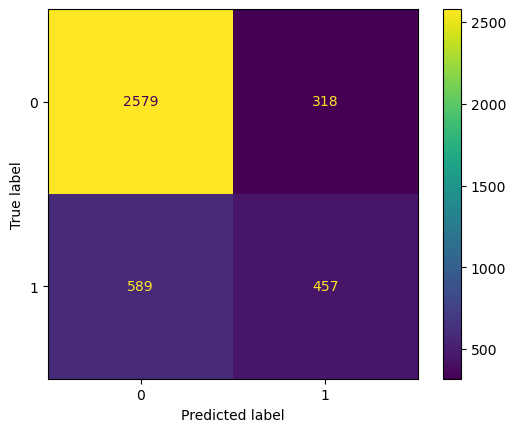

In [44]:
#best model with info:
# Make the model
forest2 = RandomForestClassifier(max_depth=7, min_samples_leaf = 7, random_state=124)

# Fit the model (on train and only train)
forest2.fit(X_test, y_test)

# Use the model
y_pred = forest.predict(X_test)

#graph the model
ConfusionMatrixDisplay.from_estimator(forest2, X_train, y_train);

In [45]:
X_test.head()

,senior_citizen_1,contract_type_One year,contract_type_Two year,internet_service_type_Fiber optic,internet_service_type_None,monthly_charges,payment_type_Credit card (automatic),payment_type_Electronic check,payment_type_Mailed check
customer_id,,,,,,,,,
4686-UXDML,0,0,0,1,0,99.85,1,0,0
3186-BAXNB,0,0,0,1,0,91.70,0,1,0
6857-VWJDT,0,0,0,1,0,95.65,0,0,1
5231-FIQPA,0,0,1,0,1,19.85,0,0,1
5522-NYKPB,0,0,0,1,0,85.90,0,1,0


In [46]:
# calculate with predictions
conf = confusion_matrix(y_test, y_pred)
TN, FP, FN, TP = conf.ravel()
wr.calculate_classification_metrics(TN, FP, FN, TP )
wr.get_metrics(forest2, X_test, y_test, test)

Accuracy: 0.7679205110007097

True Positive Rate/Sensitivity/Recall/Power: 0.4197860962566845
False Positive Rate/False Alarm Ratio/Fall-out: 0.10628019323671498
True Negative Rate/Specificity/Selectivity: 0.893719806763285
False Negative Rate/Miss Rate: 0.5802139037433155

Precision/PPV: 0.5880149812734082
F1 Score: 0.48985959438377535

Support (0): 374
Support (1): 1035

    BASELINE accuracy is: 73.46%
    The accuracy for our model is: 78.99% 
    


,0,1
precision,0.827281,0.639286
recall,0.902415,0.478610
f1-score,0.863216,0.547401
support,1035.000000,374.000000


# Conclusions

1. Summary: Based on everything I looked at I would recomend:
    - How often do people churn: Not often, in the data about 73 percent of customer do not churn.
    - Is churn impacted by type of service: Fiber churns more often compared to other.
    - Is churn impacted by finalnical features: Churn is mostly impacted by montly charges compared to tenure and total charges.
    - Interesting things found in the data: Services are not utilized often. 
    
2. Recomendations:

    - Figuring out a way to make services such as streaming more desirable. They could lead to even more profit. 
    - Looking at making servcies such as online protection, and tech support, more avaliable or more advertising.
    - Talk to senior citizens and disccuss methods that could make options to stay at telco easier. Maybe they are getting overwhelmed by tecnology or don't understand how to properly work with the services provided by Telco.<br>
    - Try lowering the cost of Fiber, it may be to expensive month to month which is why people may be churning. 
    - Advertise the other contracts with incentives or deals to make them more appeling to lower the amount of customers that use month to month service.<br>

3. Next steps:
    - Improving functions to make work flow smoother
    - Try to combinded functions
    - Look a combined varibles in hypothesis testing
    - Senior Citizen: How old are these individuals? Can we make an age column
    - What do streaming services provide? Why do customers decline?

## Lets make predictions on the entire data set and make it into a csv

In [47]:
train.head()

,tenure,monthly_charges,total_charges,did_churn,gender_Male,senior_citizen_1,partner_Yes,dependents_Yes,phone_service_Yes,multiple_lines_No phone service,...,streaming_movies_No internet service,streaming_movies_Yes,paperless_billing_Yes,contract_type_One year,contract_type_Two year,internet_service_type_Fiber optic,internet_service_type_None,payment_type_Credit card (automatic),payment_type_Electronic check,payment_type_Mailed check
customer_id,,,,,,,,,,,,,,,,,,,,,
0661-KBKPA,53,78.75,3942.45,0,1,0,1,1,1,0,...,0,1,1,1,0,0,0,0,0,1
0269-XFESX,23,24.35,538.50,0,1,0,1,1,1,0,...,1,0,0,1,0,0,1,0,0,1
2506-CLAKW,6,98.15,567.45,1,0,0,0,0,1,0,...,0,1,1,0,0,1,0,0,0,0
9381-NDKME,24,40.65,933.30,1,0,1,1,0,0,1,...,0,1,1,0,0,0,0,1,0,0
5687-DKDTV,4,20.35,77.50,1,0,0,0,0,1,0,...,1,0,0,0,0,0,1,0,0,1


In [48]:
# add them back togther
df_telco = pd.concat([train, val, test], axis=0)

In [49]:
df_telco.head(1)

,tenure,monthly_charges,total_charges,did_churn,gender_Male,senior_citizen_1,partner_Yes,dependents_Yes,phone_service_Yes,multiple_lines_No phone service,...,streaming_movies_No internet service,streaming_movies_Yes,paperless_billing_Yes,contract_type_One year,contract_type_Two year,internet_service_type_Fiber optic,internet_service_type_None,payment_type_Credit card (automatic),payment_type_Electronic check,payment_type_Mailed check
customer_id,,,,,,,,,,,,,,,,,,,,,
0661-KBKPA,53,78.75,3942.45,0,1,0,1,1,1,0,...,0,1,1,1,0,0,0,0,0,1


In [50]:
# make the features the same 
df_telco_data = df_telco[features]
df_telco_target = df_telco.did_churn
customer_ids = telco['customer_id']

In [51]:
# predicts the churn
prediction_of_churn = pd.DataFrame({'churn_prediction' : forest2.predict(df_telco_data[features])})
# predicts the probabtility 
churn_probability = pd.DataFrame({'churn_probability': forest2.predict_proba(df_telco_data)[:,1]})
data = [customer_ids, churn_probability, prediction_of_churn]
customer_churn = pd.concat(data, axis=1)
customer_churn.to_csv(r'customer_churn.csv', index = False)

In [52]:
#read the csv: 
df = pd.read_csv('customer_churn.csv')
df

,customer_id,churn_probability,churn_prediction
0,0002-ORFBO,0.124452,0
1,0003-MKNFE,0.034251,0
2,0004-TLHLJ,0.399856,0
3,0011-IGKFF,0.324288,0
4,0013-EXCHZ,0.253576,0
...,...,...,...
7038,9987-LUTYD,0.028053,0
7039,9992-RRAMN,0.004358,0
7040,9992-UJOEL,0.190837,0
7041,9993-LHIEB,0.664226,1
